In [1]:
import pandas as pd
from auto_ml_regression.preprocessing import DataPreprocessor

data = pd.read_csv('../../datasets/insurance_dataset/insurance.csv')
target_col="charges"
N_SEGMENTS = 2

cat_features = data.select_dtypes(include='object').columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list()
num_features.remove(target_col)
cat_features_saved = [f'CAT_{i}' for i in cat_features]

# Инициализация и применение препроцессора
preprocessor = DataPreprocessor(
    target_col=target_col,
    cat_encoder_type="target",  # или "ohe"
    fillna_num_strategy="mean",
    scaler_type="minmax",
    test_size=0.3,
    random_state=2025,
)

train_df, test_df = preprocessor.fit_transform(data)

In [2]:
from auto_ml_regression.segmentation.kmeans import KMeansSegmenter

segmenter = KMeansSegmenter(N_SEGMENTS, plot=False)
segmented_train = segmenter.fit(train_df.copy(), target_col)

In [3]:
from auto_ml_regression.modeling.classifier import SegmentClassifier
from sklearn import metrics
import numpy as np

# ohe_cat_cols = list(set(segmented_train.columns) - set(num_features) - set(cat_features_saved) - set([target_col]))
# 2. Инициализация и обучение классификатора сегментов
clf = SegmentClassifier(
    features=num_features+cat_features_saved,
    cat_features=cat_features_saved, 
    n_segments=N_SEGMENTS
)

# Обучаем на сегментированных данных
clf.fit(
    X=segmented_train[num_features+cat_features_saved],
    y=segmented_train['segment'],
    n_trials=50  # Количество итераций Optuna
)


/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-18 15:41:16,459] A new study created in memory with name: no-name-26420d45-ec2c-4110-a4e9-08a94e8ae585
[I 2025-05-18 15:41:16,586] Trial 0 finished with value: 0.9417494270435447 and parameters: {'iterations': 1945, 'learning_rate': 0.17636559389642503, 'l2_leaf_reg': 0.01764298246309653, 'random_strength': 0.013397457062266454, 'bagging_temperature': 0.26452823039446516, 'border_count': 66, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 9, 'grow_policy': 'SymmetricTree', 'od_type': 'Iter', 'od_wait': 27, 'one_hot_max_size': 128}. Best is trial 0 with value: 0.9417494270435447.
[I 2025-05-18 15:41:16,628] Trial 1 finished with value: 0.9557868601986249 and parameters: {'iterations': 6

Classification Report: TRAIN
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       170
           1       0.96      1.00      0.98       766

    accuracy                           0.96       936
   macro avg       0.98      0.90      0.93       936
weighted avg       0.96      0.96      0.96       936

ROC AUC = 0.9893910305636615


In [4]:
# 3. Предсказание на тестовых данных
# Сначала сегментируем тестовые данные (используем тот же segmenter)
segmented_test = segmenter.predict(test_df, target_col=target_col)
# Предсказание сегментов
test_segment_probs = clf.model.predict_proba(segmented_test[num_features+cat_features_saved])
test_segments = clf.model.predict(segmented_test[num_features+cat_features_saved])
segmented_test['segment_probs'] = test_segment_probs[:, 1]
segmented_test['segment_preds'] = test_segments 

print(f"TEST ROC AUC - {metrics.roc_auc_score(segmented_test['segment'], test_segment_probs[:, 1], multi_class='ovr')}")#[:, 1]


TEST ROC AUC - 0.9123906515210862


In [5]:
from auto_ml_regression.modeling.linear_regs import SegmentLinearModels

lr = SegmentLinearModels(features=num_features+cat_features,
                         model_type='huber',
                         use_optuna=True,
                         n_trials=50,
                         cv=4)
lr.fit(segmented_train, 
       segmented_train['charges'], 
       segments=segmented_train['segment'])

[I 2025-05-18 15:41:24,483] A new study created in memory with name: no-name-a016107a-32c5-4d5e-841f-f618118a3ee4
[I 2025-05-18 15:41:24,514] Trial 0 finished with value: -4251.078324388638 and parameters: {'epsilon': 5.6997101854714485, 'alpha': 0.05918201729461137, 'fit_intercept': True}. Best is trial 0 with value: -4251.078324388638.
[I 2025-05-18 15:41:24,536] Trial 1 finished with value: -6857.042677296919 and parameters: {'epsilon': 2.538517974520926, 'alpha': 0.1582386829011615, 'fit_intercept': False}. Best is trial 0 with value: -4251.078324388638.
[I 2025-05-18 15:41:24,559] Trial 2 finished with value: -4761.402338473967 and parameters: {'epsilon': 6.611476842935188, 'alpha': 0.048566687643435316, 'fit_intercept': False}. Best is trial 0 with value: -4251.078324388638.
[I 2025-05-18 15:41:24,581] Trial 3 finished with value: -4837.917849641769 and parameters: {'epsilon': 2.8822271329913614, 'alpha': 0.05138277178606604, 'fit_intercept': False}. Best is trial 0 with value: -

In [6]:
test_target_preds = lr.predict(segmented_test, 
                              segments=segmented_test['segment_preds'],
                              )
                              # use_weighted=True,
                              # segment_probs=test_segment_probs

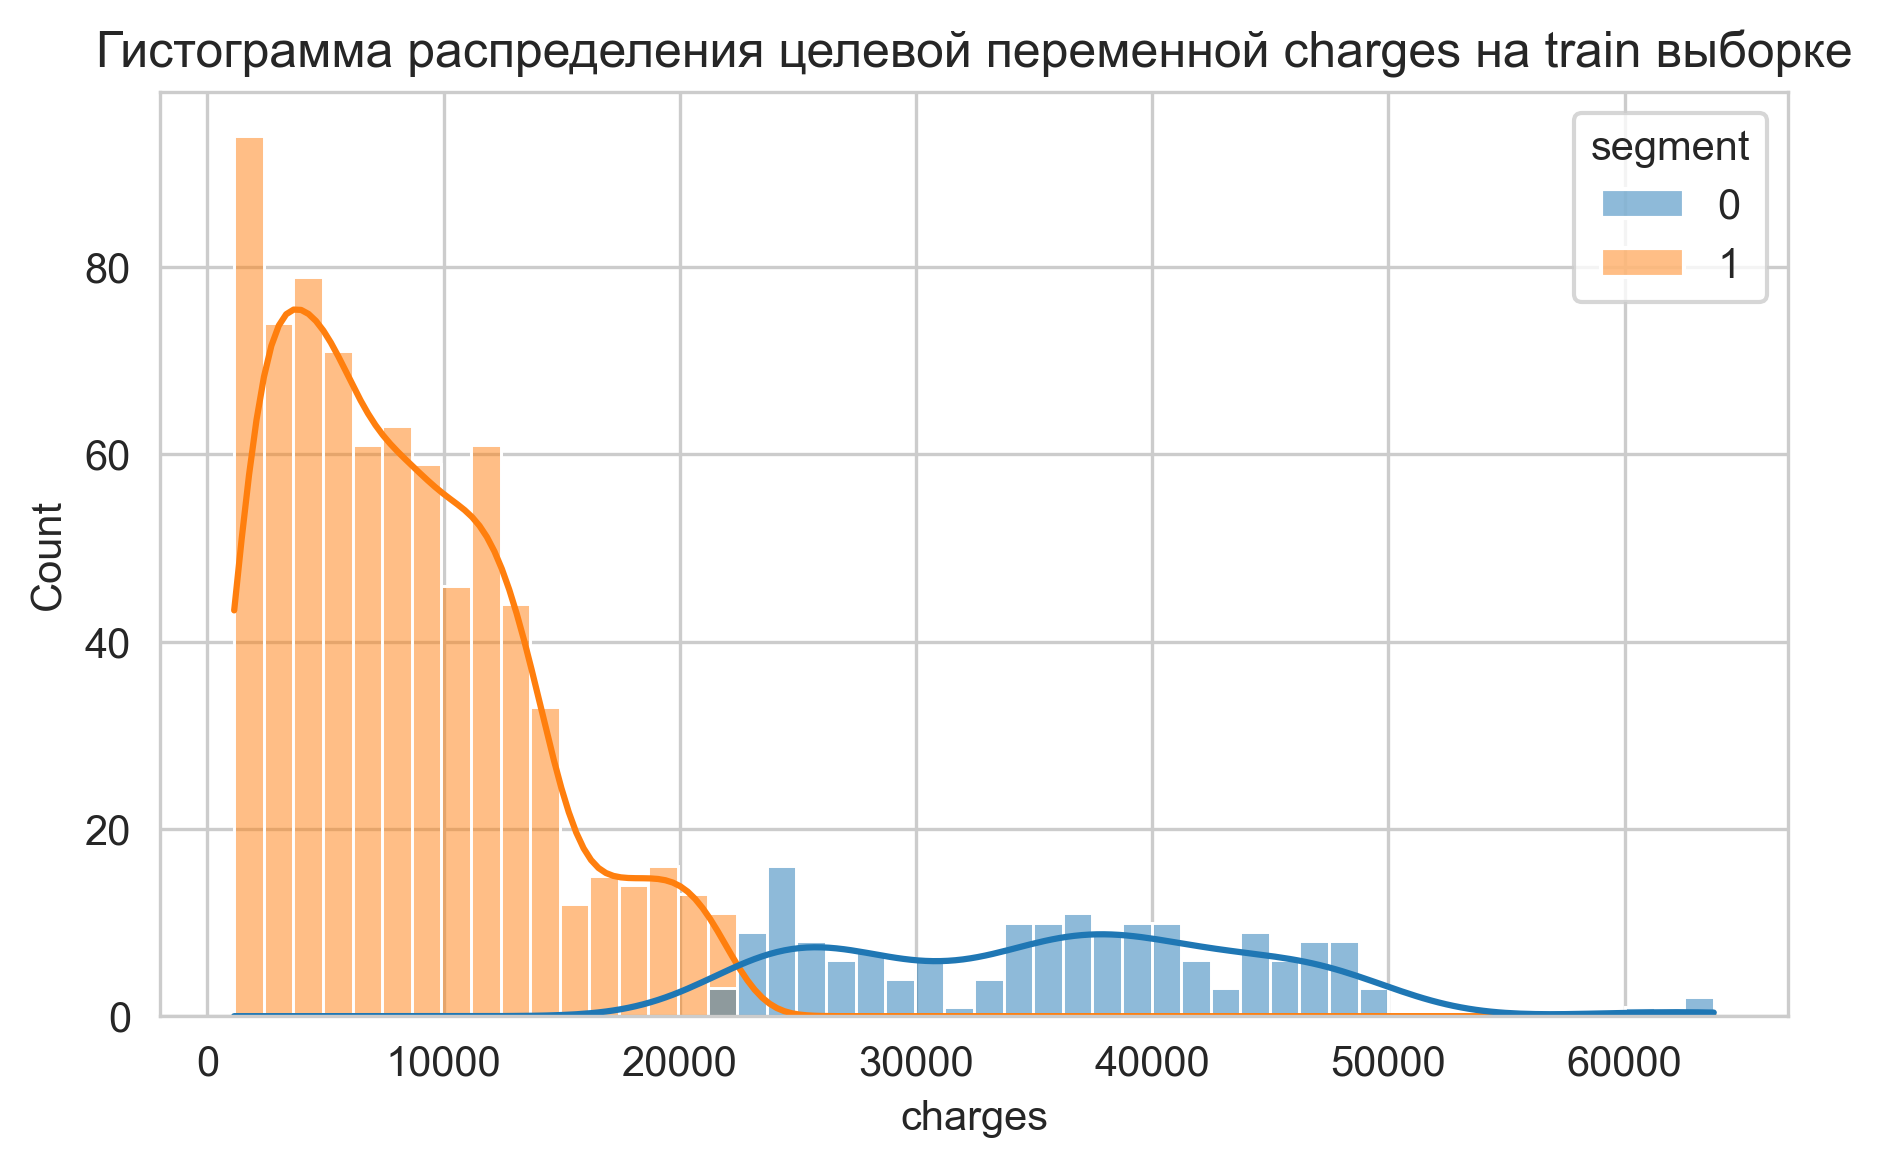

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4), dpi=300)
plt.title("Гистограмма распределения целевой переменной charges на train выборке")
sns.set_style("whitegrid")
sns.histplot(segmented_train, x=target_col, hue='segment', bins=50, kde=True)
plt.show();

In [7]:
lr.get_model_coefs()

,model_coef_segment_0,model_coef_segment_1
intercept_,11799.418980,1426.855814
age,6284.875392,11860.703223
bmi,29548.789408,215.996033
children,-484.728247,2087.309628
sex,572.553400,-386.574784
smoker,9157.510179,13466.679433
region,-442.219141,-313.569369


In [8]:
N = len(lr.models)
stat = pd.DataFrame(columns = [f'model_coef_segment_{m}' for m in range(N)],
             index = ['intercept_'] + list(lr.models[0].feature_names_in_))
for m in range(N):
     x = list([lr.models[m].intercept_])
     x.extend(list(lr.models[m].coef_))
     stat[f'model_coef_segment_{m}'] = x

stat

,model_coef_segment_0,model_coef_segment_1
intercept_,11799.418980,1426.855814
age,6284.875392,11860.703223
bmi,29548.789408,215.996033
children,-484.728247,2087.309628
sex,572.553400,-386.574784
smoker,9157.510179,13466.679433
region,-442.219141,-313.569369


In [9]:
pd.DataFrame(zip(lr.models[0].feature_names_in_, lr.models[0].coef_))

,0,1
0,age,6284.875392
1,bmi,29548.789408
2,children,-484.728247
3,sex,572.553400
4,smoker,9157.510179
5,region,-442.219141


In [10]:
lr.models[0].coef_

array([ 6284.87539192, 29548.78940779,  -484.72824742,   572.55340023,
        9157.51017932,  -442.2191412 ])

In [11]:
test_target_true = segmented_test.charges

In [12]:
r2 = metrics.r2_score(test_target_true, test_target_preds)
mse = metrics.mean_squared_error(test_target_true, test_target_preds)
mae = metrics.mean_absolute_error(test_target_true, test_target_preds)
mape = metrics.mean_absolute_percentage_error(test_target_true, test_target_preds)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.8204424946275874
MSE = 25577441.49469838
RMSE = 5057.414506909472
MAE = 2271.436672618187
MAPE = 0.14703939940246216


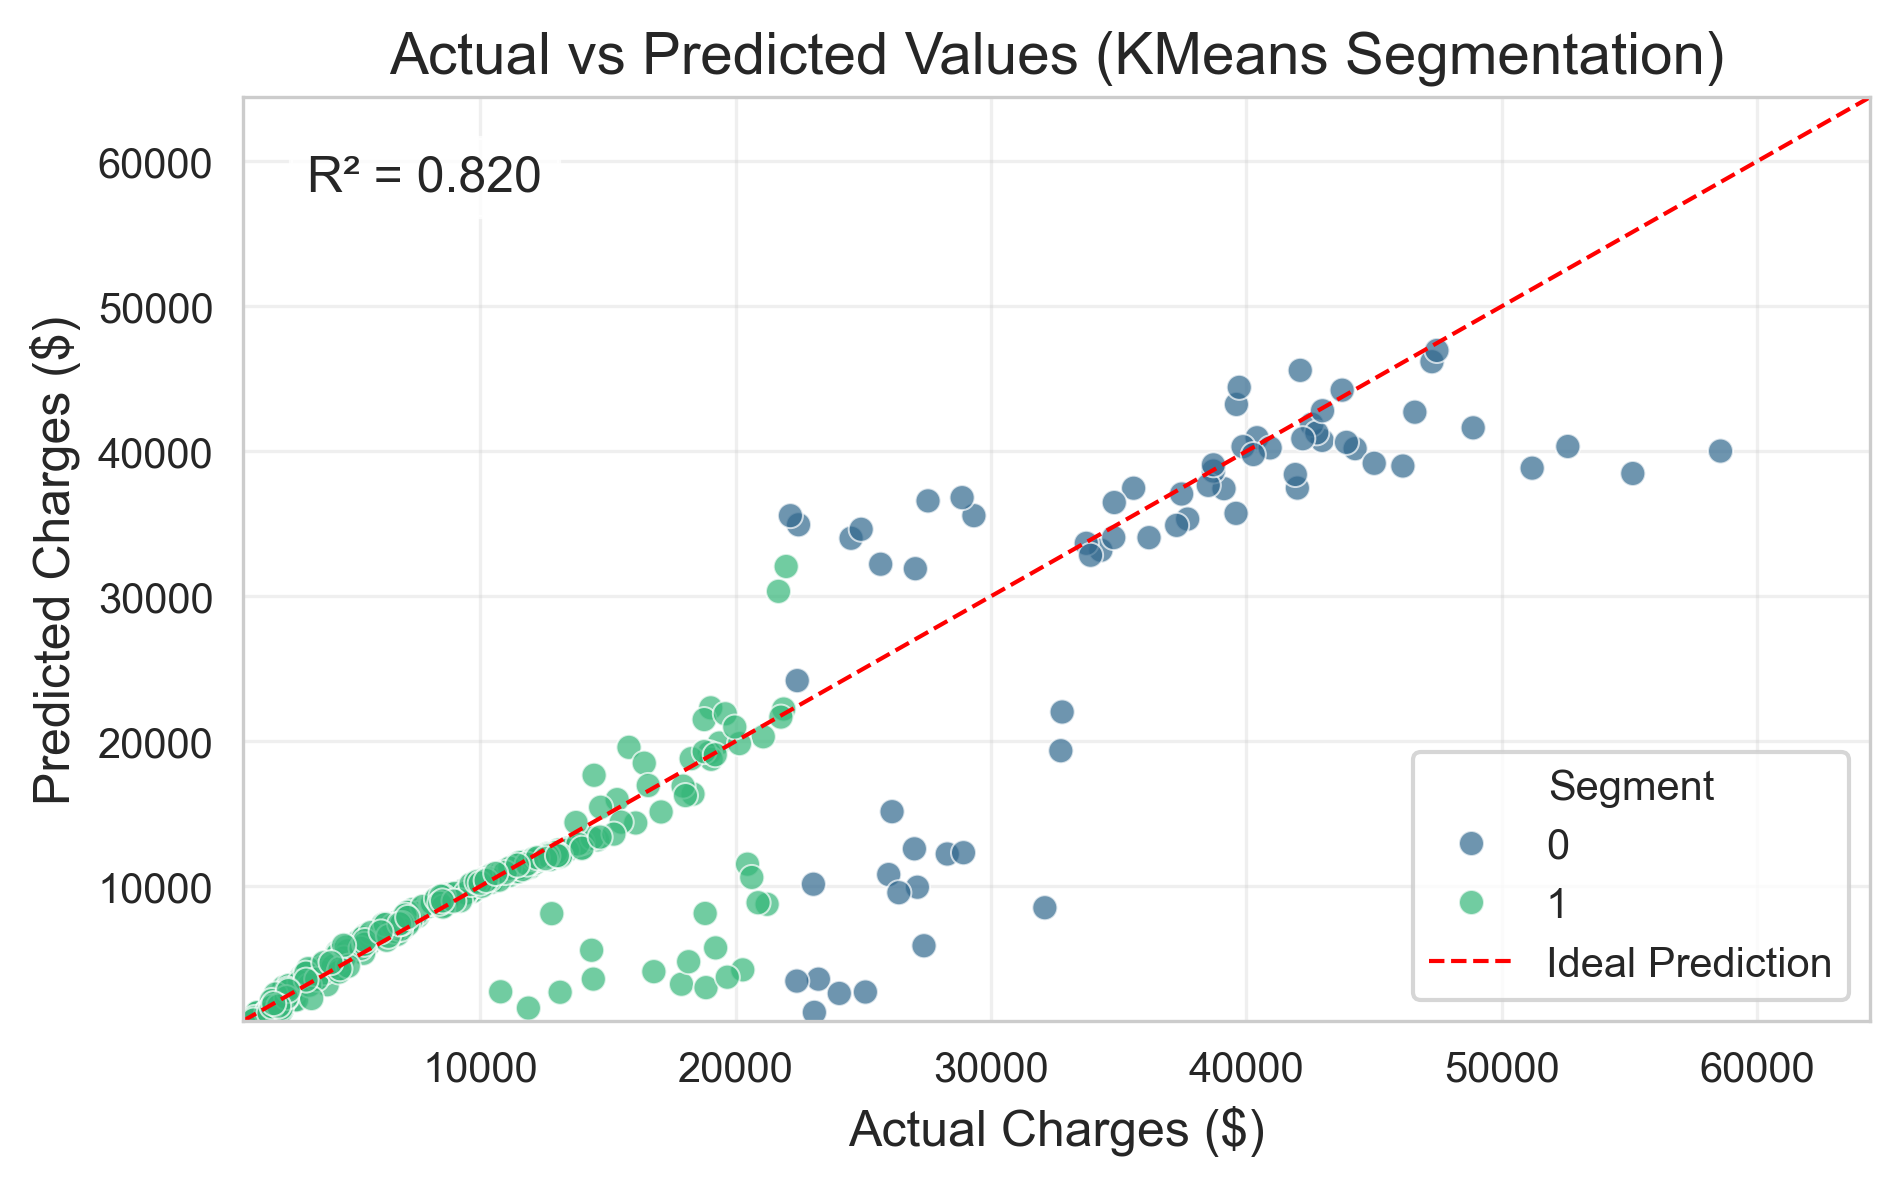

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Предположим, у нас есть:
# y_test - истинные значения на тестовой выборке
# y_pred - предсказания модели CatBoost+KMeans на тестовой выборке
y_test = test_target_true
y_pred = test_target_preds

# Создаем DataFrame для визуализации
plot_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Segment': segmented_test['segment']  # Добавляем информацию о сегментах
})

# Определяем границы осей (минимальное/максимальное значение + 10%)
ax_min = min(y_test.min(), y_pred.min()) * 0.9
ax_max = max(y_test.max(), y_pred.max()) * 1.1

# Создаем фигуру
plt.figure(figsize=(7, 4), dpi=300)

# Диаграмма рассеяния с цветовым кодированием по сегментам
scatter = sns.scatterplot(
    data=plot_data,
    x='Actual',
    y='Predicted',
    hue='Segment',
    palette='viridis',
    alpha=0.7
)

# Добавляем идеальную линию
ideal_line = plt.plot(
    [ax_min, ax_max],
    [ax_min, ax_max],
    '--',
    color='red',
    linewidth=1,
    label='Ideal Prediction'
)

# Настройки графика
plt.title('Actual vs Predicted Values (KMeans Segmentation)', fontsize=14)
plt.xlabel('Actual Charges ($)', fontsize=12)
plt.ylabel('Predicted Charges ($)', fontsize=12)
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.legend(title='Segment')
plt.grid(True, alpha=0.3)

# Добавляем коэффициент R² в аннотацию
r2 = metrics.r2_score(y_test, y_pred)
plt.text(
    x=ax_max*0.05,
    y=ax_max*0.9,
    s=f'R² = {r2:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()